# 🎵Music🎵 Generation using LSTM Networks

In this notebook, the model is trained with beeth (beethoven) music from the classical-music-midi dataset. Simply with replacing the dirpath in the 2nd code cell with other music album, the model can be trained on that music.

Each album contains music in the form of MIDI files. 
MIDI (Musical Instrument Digital Interface) is a technical standard that describes a communication protocol, digital interface, and electrical connectors that connect a wide variety of electronic musical instruments, computers, and related audio devices for playing, editing and recording. When a musician plays an MIDI instrument, all of the key presses, button presses, knob turns and slider changes are converted into MIDI data (source: [MIDI - Wikipedia](https://en.wikipedia.org/wiki/MIDI)).

In [1]:
import os
os.chdir('/kaggle/input')
!pip install music21
from utils1.music_utils import * # importing all the required modules and user functions
from utils1.mytfutils import *
from modelxarchitecture.modelxarchitecture import MyModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 59.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.0 MB/s eta 0:00:00


2024-03-24 23:31:32.960320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 23:31:32.960430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 23:31:33.123030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading Data and Parsing Data

#### Creating dataset from midi files

In [2]:
# define args
dirpath = "classical-music-midi/beeth" # change the dirpath depending on the music album you wanna train with
length = 30
name = os.path.basename(dirpath)
in_kaggle = True

# process data
dataset = CreateDataset(dirpath, length=length, name=name, in_kaggle=in_kaggle)
dataset.make_mappings()

Using the make_mappings() method, we basically do all the tasks from parsing the midi files to mapping the parsed notes and chords with the numbers (normalized).

In [3]:
dataset.features[0] # After parsing

array(['D4', 'E-4', 'F4', 'A4:G4', 'F4', 'G4', 'A4', 'B-4', 'F4', 'A4:G4',
       'F4', 'G4', 'A4', 'B-4', 'A4', 'B-4', 'C5', 'D5', 'E5', 'B-4:E5',
       'A4:F5', 'F5:E-5', 'D5', 'E-5', 'F5', 'G5', 'C5', 'D5:C5', 'B4',
       'C5'], dtype='<U29')

In [4]:
dataset.features_normalized[0] # After mapping to normalized numbers

array([0.44308879, 0.53592967, 0.7696762 , 0.06034151, 0.7696762 ,
       0.95738174, 0.04136858, 0.12687326, 0.7696762 , 0.06034151,
       0.7696762 , 0.95738174, 0.04136858, 0.12687326, 0.04136858,
       0.12687326, 0.38009866, 0.46813306, 0.63180622, 0.1402808 ,
       0.05932962, 0.8109107 , 0.46813306, 0.55996205, 0.79775613,
       0.97964331, 0.38009866, 0.47648115, 0.20554769, 0.38009866])

Similarly, the labels have been one hot encoded

In [5]:
dataset.labels[0]

'D5'

In [6]:
dataset.labels_encoded[0]

array([0., 0., 0., ..., 0., 0., 0.])

Creating train and seed sets\
Generate set is for generating new music using a single sample from it

In [7]:
test_size = 0.01
random_state = 42
x_train, x_gen, y_train, y_gen = train_test_split(dataset.features_normalized, dataset.labels_encoded, test_size=test_size, random_state=random_state)

In [8]:
num_features = 1
x_train = x_train.reshape((-1, dataset.length, num_features)) # just making it as an appropriate input to the model

Building and training the model

Model Architecture and Class

In [9]:
@tf.keras.utils.register_keras_serializable()
class MyModel(tf.keras.Model):
    def __init__(self, input_shape_, input_units, output_units, **kwargs):
        """
            input_shape: A tuple length representing (time_steps, features)
            input_units: number of units in the first layer (lstm layer)
            output_units: number of units in the output layer
        """
        super(MyModel, self).__init__(**kwargs)
        self.input_shape_ = input_shape_
        self.input_units = input_units
        self.output_units = output_units

        # Layers
        self.lstm1 = tf.keras.layers.LSTM(self.input_units, input_shape=self.input_shape_, return_sequences=False)
        self.dense1 = tf.keras.layers.Dense(512)
        self.batchNorm1 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(448)
        self.batchNorm2 = tf.keras.layers.BatchNormalization()
        self.dense_output = tf.keras.layers.Dense(self.output_units, activation='softmax')

    def call(self, inputs, training=False):    
        x = self.lstm1(inputs)
        x = self.dense1(x)
        x = self.batchNorm1(x, training=training)
        x = self.dense2(x)
        x = self.batchNorm2(x, training=training)
        x = self.dense_output(x)
        return x

    def get_config(self):
        config = super(MyModel, self).get_config()
        config.update({
            "input_shape_":self.input_shape_,
            "input_units":self.input_units,
            "output_units":self.output_units
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

Creating the model and training

In [10]:
def create_compile_model():
    scaling = 4
    model_args = {}
    model_args["input_shape_"] = x_train.shape[1:]
    model_args["input_units"] = len(dataset.mapping)//scaling
    model_args["output_units"] = y_train.shape[1]
    model = MyModel(**model_args)

    compile_args = {}
    compile_args["loss"] = 'categorical_crossentropy'
    compile_args["optimizer"] = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(**compile_args)
    
    return model

In [11]:
model = create_compile_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Getting details about model's layers

In [12]:
inputs = tf.keras.Input(shape=x_train.shape[1:])
outputs = model(inputs)
intermediary_outputs = []
for layer in model.layers:
    inputs = layer(inputs)
    intermediary_outputs.append(inputs)
new_model = tf.keras.Model(inputs=model.input, outputs=intermediary_outputs)
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 988)            │     3,912,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       506,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 448)            │       229,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 448)            │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3916)           │     1,758,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,410,796 (24.46 MB)

 Trainable params: 6,408,876 (24.45 MB)

 Non-trainable params: 1,920 (7.50 KB)

Training the model

In [13]:
# defining the callbacks
def create_callbacks():
    callbacks = [EarlyStopping(monitor="loss", min_delta=0.002, patience=10, verbose=1, mode="auto", baseline=None, restore_best_weights=True,),
                 ReduceLROnPlateau(monitor="loss", factor=0.1, patience=4, verbose=1, mode="auto", min_delta=0.01, cooldown=0, min_lr=1e-9)]
    return callbacks

In [14]:
num_epochs = 200
callbacks = create_callbacks()
history = model.fit(x_train, y_train, batch_size=96,epochs=num_epochs, callbacks=callbacks, verbose=1)

Epoch 1/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - loss: 6.7589 - learning_rate: 0.0010
Epoch 2/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 5.5029 - learning_rate: 0.0010
Epoch 3/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 5.3218 - learning_rate: 0.0010
Epoch 4/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 5.1516 - learning_rate: 0.0010
Epoch 5/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - loss: 4.9776 - learning_rate: 0.0010
Epoch 6/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 4.8289 - learning_rate: 0.0010
Epoch 7/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 4.6371 - learning_rate: 0.0010
Epoch 8/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 4.3375 - learning_rate: 0.0010
Epoch 9/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 3.9351 - learning_rate: 0.0010
Epoch 10/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 3.4758 - learning_rate: 0.0010
Epoch 11/200
830/830 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - l

Saving the model

In [15]:
path_to_save = '/kaggle/working/'
filename = dataset.name+f"_{dataset.length}"
save_model_as_json_h5(path_to_save, filename, model)

Train Plot

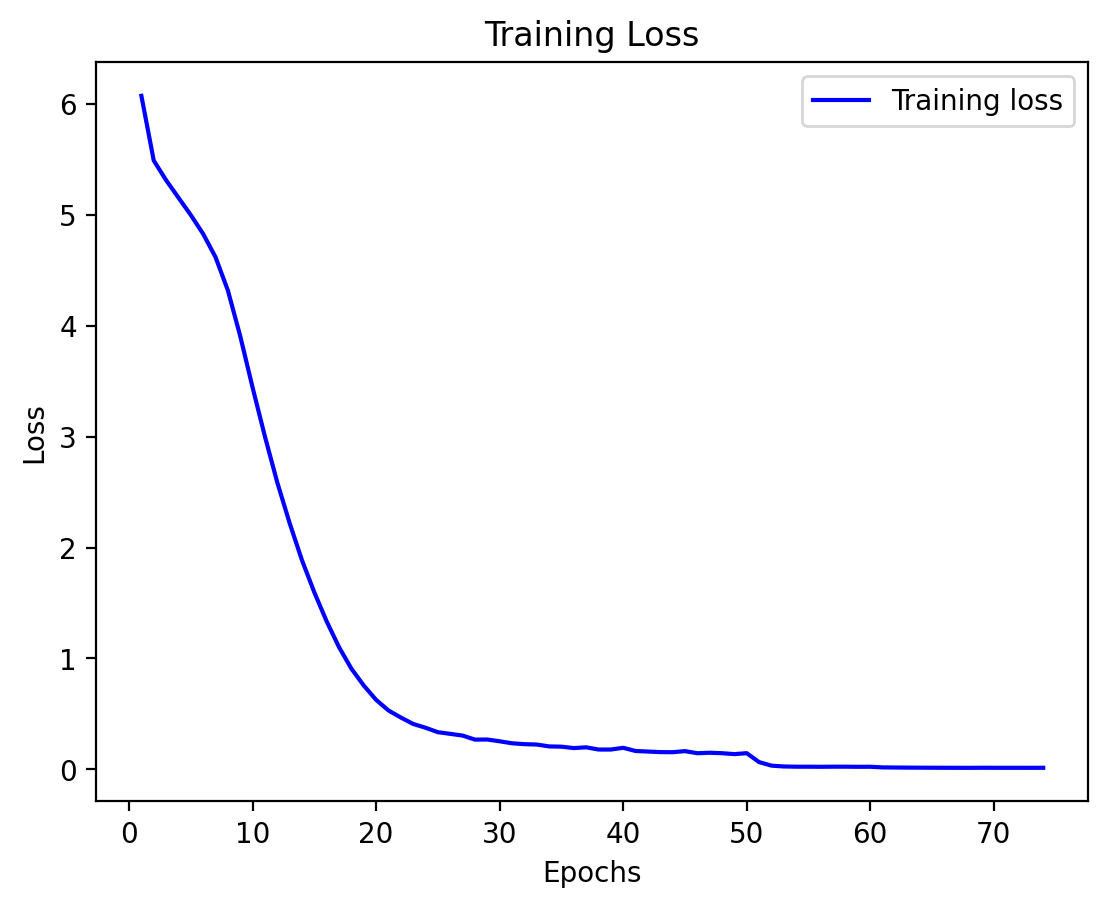

<Figure size 640x480 with 0 Axes>

In [16]:
def make_train_plot():
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig(path_to_save+f'/{name}_{dataset.length}.png')
make_train_plot()

In [18]:
generator = Generator(model, x_gen, dataset)

In [19]:
count = 0
note_count = 200
num_songs = 10
generator.create_playlist(num_songs, note_count, direc_name = path_to_save+f"/music{count}", zip_file=True)
count+=1